# Classification using 'video list'

In [125]:
#default_exp nb_07

In [1]:
#export
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *
from kgl_deepfake.nb_03 import *

In [6]:
# from fastai.utils import show_install
#show_install()

### Data

In [5]:
ls ../data

deepfake-detection-challenge.zip  dfdc_train_part_1/  train_sample_videos/
dfdc_train_part_0/                test_videos/


In [114]:
SOURCE = Path('../data/')

In [104]:
SOURCE = Path('../data/dfdc_train_part_0')

In [47]:
f = get_files(SOURCE, extensions=['.json'], recurse=True)

In [139]:
#export
def get_annots(SOURCE):
    """
    extract the metadata from all the folders contained in SOURCE.
    """
    
    files = []
    annots = []
    
    for i in SOURCE.iterdir(): # iterate over the files in SOURCE
        if i.is_dir() and (i/'metadata.json').is_file(): # Get only the directories
            print(f'Extracting data from the {i.name} folder')
            f = get_files(i, extensions=['.json']) # Extract the metadata
            files.append(f) 
            
            a = pd.read_json(f[0]).T
            a.reset_index(inplace=True)
            a.rename({'index':'fname'}, axis=1, inplace=True)
            a.fname = i.name + '/' + a.fname.astype(str)
            annots.append(a)

    
    return pd.concat(annots)

In [144]:
annots = get_annots(SOURCE)

Extracting data from the dfdc_train_part_0 folder
Extracting data from the dfdc_train_part_1 folder
Extracting data from the train_sample_videos folder


In [145]:
annots.head()

,fname,label,split,original
0,dfdc_train_part_0/owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
1,dfdc_train_part_0/vpmyeepbep.mp4,REAL,train,NaN
2,dfdc_train_part_0/fzvpbrzssi.mp4,REAL,train,NaN
3,dfdc_train_part_0/htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
4,dfdc_train_part_0/fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


#### Get face detector

In [146]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [147]:
detector = MTCNN(device=device, post_process=False)

#### Remove videos in which no faces are detected.  

In [148]:
fnames = [SOURCE/o for o in annots.fname]

In [149]:
hasface = get_has_face(fnames, detector)

In [150]:
annots_hasface = annots[np.array(hasface)]

#### Create `DataBunch`

In [151]:
src = (VideoFaceList
       .from_df(df=annots_hasface, path=SOURCE, cols='fname', detector=detector)
       .split_by_rand_pct())

In [171]:
bs, sz = 512, 128

In [180]:
%%time
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, device=device, num_workers=0).normalize(imagenet_stats))

CPU times: user 3min 1s, sys: 2.4 s, total: 3min 3s
Wall time: 47.5 s


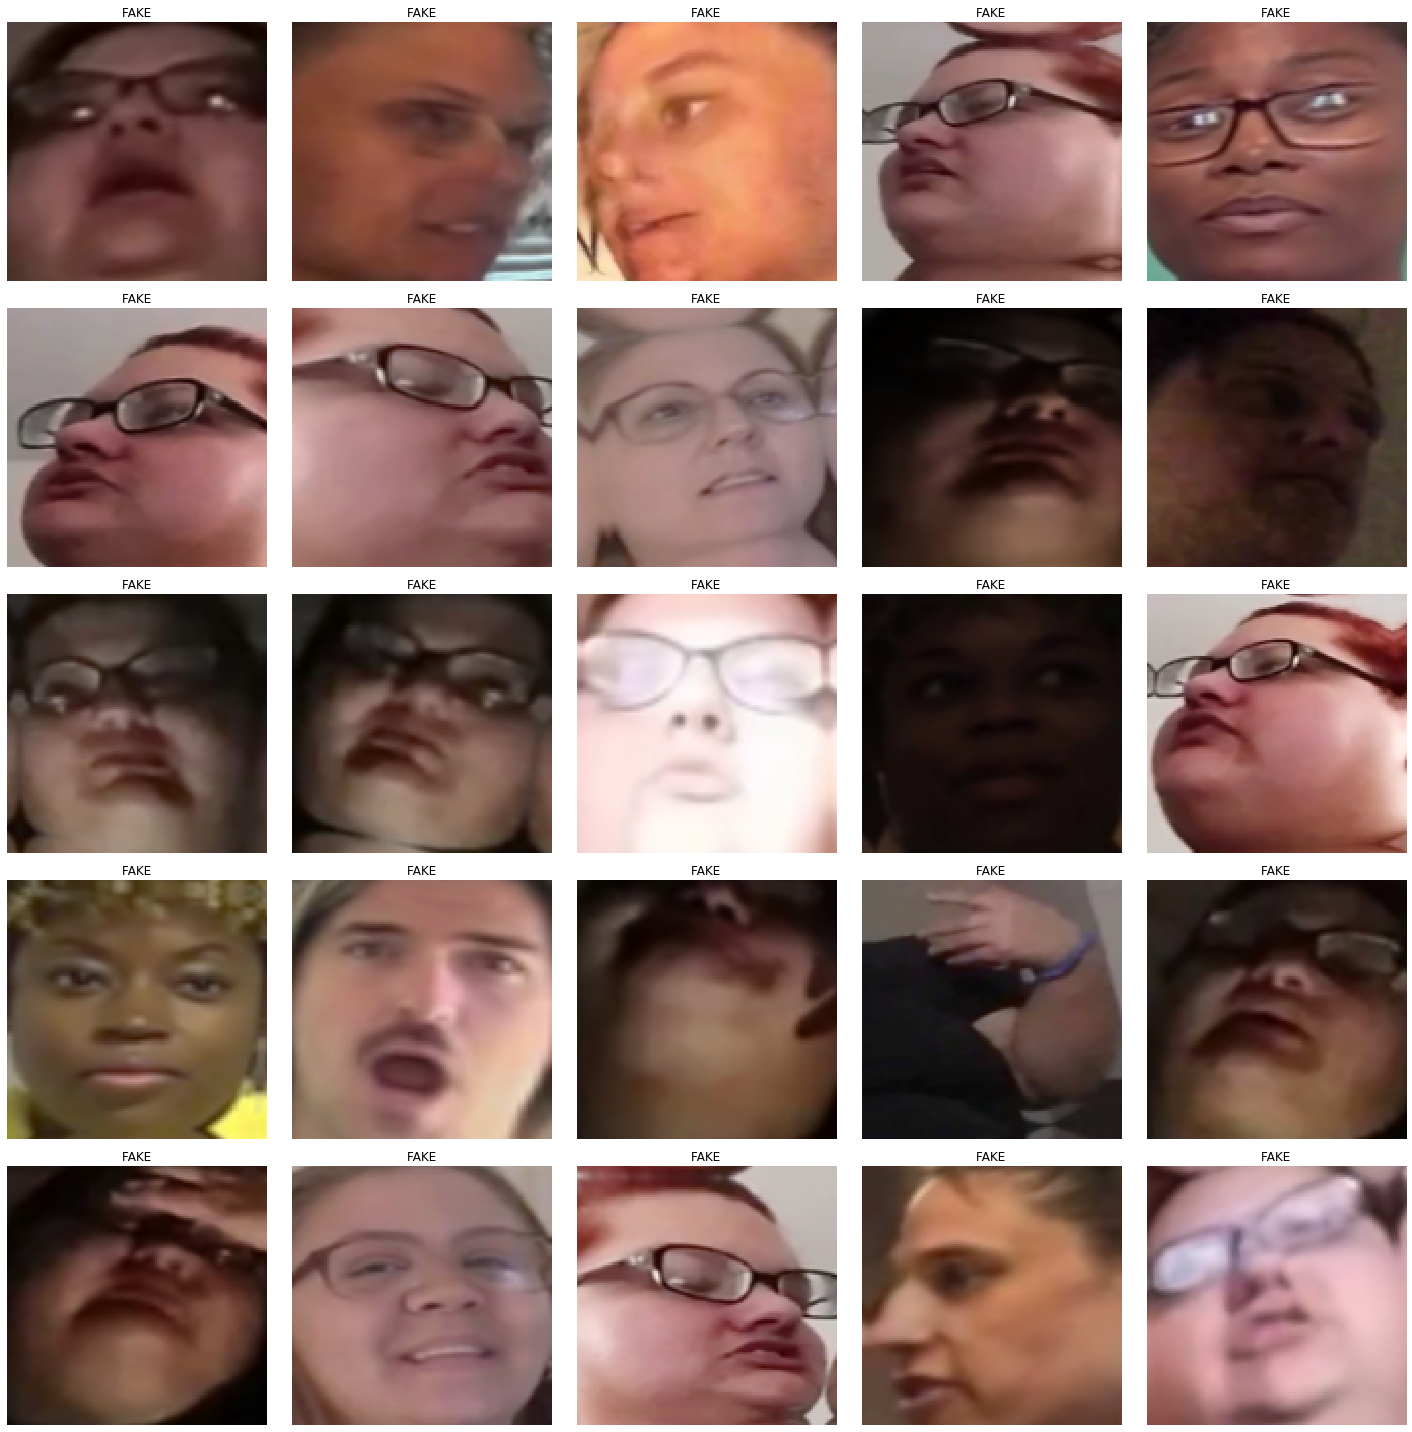

In [167]:
data.show_batch()

### Model

In [181]:
model = MesoNet()

### Learner

In [182]:
learn = Learner(data, model, metrics=accuracy)

### Train

In [183]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


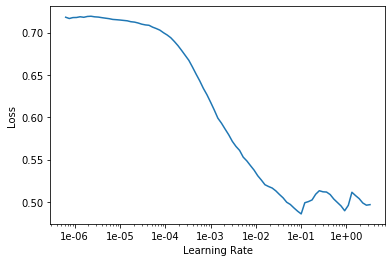

In [184]:
learn.recorder.plot()

In [185]:
learn.fit_one_cycle(cyc_len=10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.553102,0.644955,0.819259,04:41
1,0.445112,0.469960,0.862222,04:41
2,0.414293,0.344624,0.903704,04:41
3,0.395108,0.355125,0.909630,04:41
4,0.378372,0.386103,0.911111,04:41
5,0.361277,0.349853,0.914074,04:41
6,0.351980,0.317972,0.914074,04:41
7,0.343480,0.327910,0.914074,04:41
8,0.336763,0.323027,0.914074,04:41
9,0.330982,0.306651,0.914074,04:40


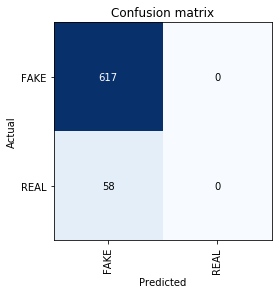

In [186]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [202]:
learn.save('mesonet_stage1')

In [203]:
learn.load('mesonet_stage1');

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fc7d05135f8>>
Traceback (most recent call last):
  File "/space/storage/homes/nathan/Babar/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/space/storage/homes/nathan/Babar/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/space/tools/python/python_3.6.5/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/space/tools/python/python_3.6.5/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/space/tools/python/python_3.6.5/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [204]:
learn.export('mesonet_stage1.pkl')

### Results

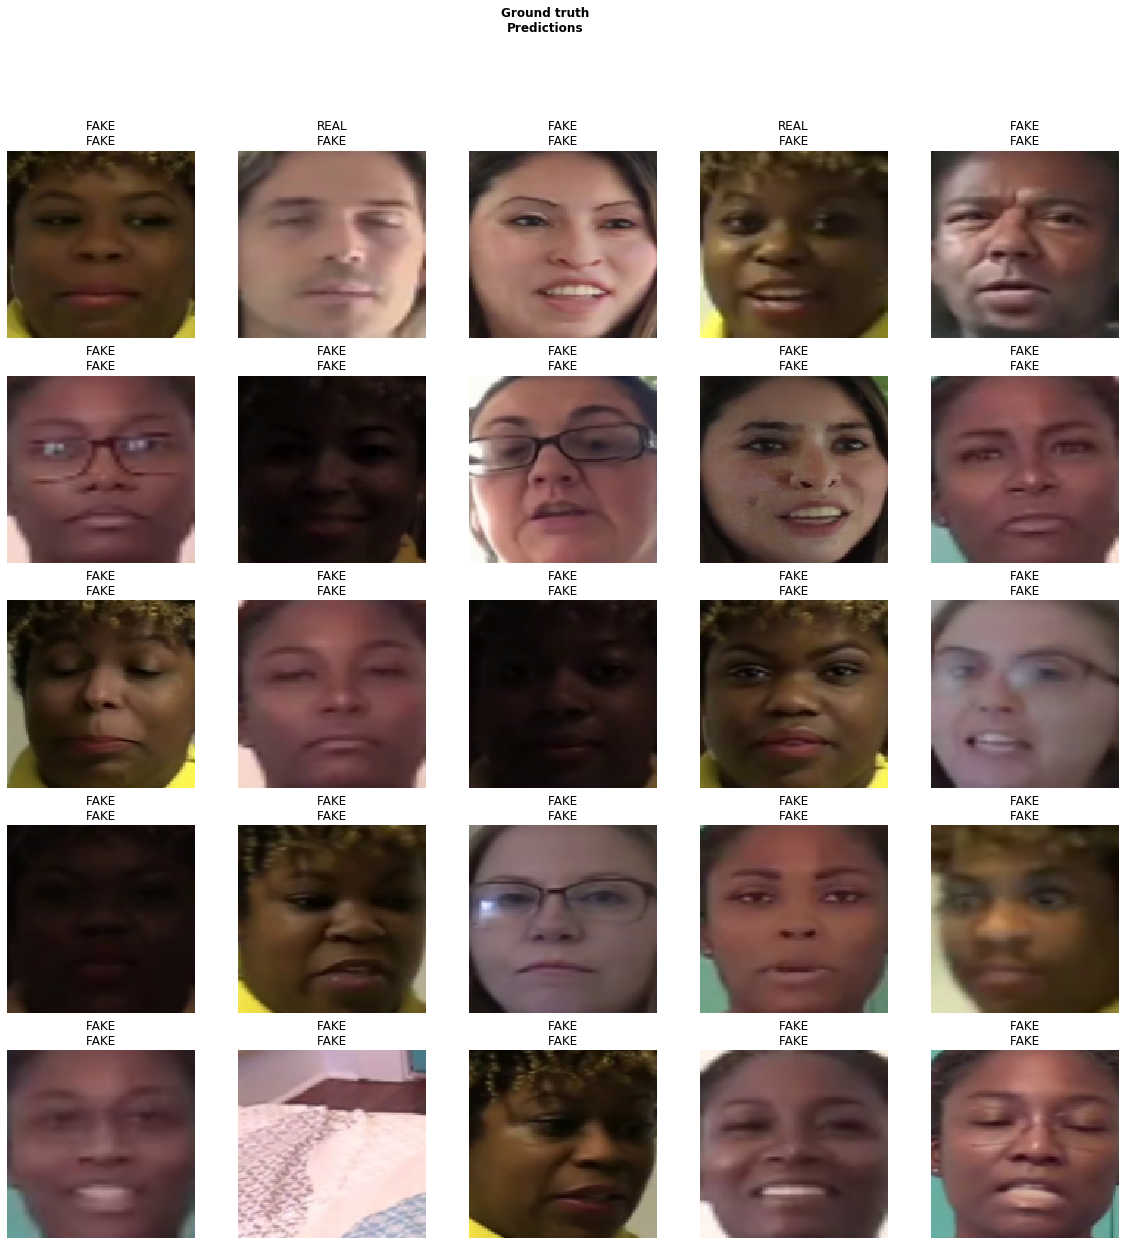

In [27]:
learn.show_results()

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

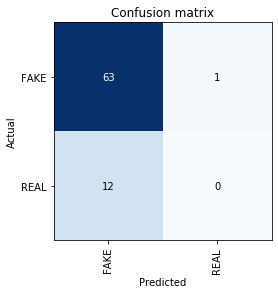

In [29]:
interp.plot_confusion_matrix()

### Inference

In [215]:
SOURCE_TEST = Path('../data/test_videos/')

In [216]:
fnames = get_files(SOURCE_TEST, extensions=['.mp4'])
fnames[:3]

[PosixPath('../data/test_videos/apedduehoy.mp4'),
 PosixPath('../data/test_videos/ajiyrjfyzp.mp4'),
 PosixPath('../data/test_videos/aqrsylrzgi.mp4')]

Again, because we can't deal with videos which have no detected face, we need to ignore them for now.

In [217]:
hasface_tst = get_has_face(fnames, detector)

In [218]:
fnames_tst_hasface = [f for f, b in zip(fnames, hasface_tst) if b]
len(fnames_tst_hasface)

395

In [219]:
vlist = VideoFaceList(sorted(fnames_tst_hasface), detector=detector)

In [213]:
learn = load_learner(path='../data', file='mesonet_stage1.pkl')

In [220]:
len(vlist_tst.items), len(vlist_tst)

NameError: name 'vlist_tst' is not defined

Note that there are 400 test videos, but we will only be able to write an entry in the submission file for 396 of these.

In [221]:
! head  ../data/sample_submission.csv

head: impossible d'ouvrir « ../data/sample_submission.csv » en lecture: Aucun fichier ou dossier de ce type


In [222]:
learn.data.classes # this is the opposite for Kaggle scoring

['FAKE', 'REAL']

In [223]:
cats = learn.data.classes[:]

In [281]:
#export
def infer_on_videolist(learn:Learner, vlist:VideoFaceList):
    filenames, labels = [], []
    for i in progress_bar(range(len(vlist))):
        fn, img = vlist.items[i], vlist[i]
        _, _, y = learn.predict(img)
        filenames.append(fn.name)
        labels.append(float(y[0]))
    return pd.DataFrame({'filename':filenames, 'label':labels})

In [ ]:
df = infer_on_videolist(learn, vlist)

In [ ]:
df

In [118]:
df.to_csv('submission.csv', index=False)

In [119]:
! head submission.csv

filename,label
aassnaulhq.mp4,0
aayfryxljh.mp4,0
acazlolrpz.mp4,0
adohdulfwb.mp4,0
ahjnxtiamx.mp4,0
ajiyrjfyzp.mp4,0
aktnlyqpah.mp4,0
alrtntfxtd.mp4,0
aomqqjipcp.mp4,1


# - fin

In [ ]:
from nbdev.export import *
notebook2script()